In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
# t_c: celsius temperature
# t_u: unknown temperature
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c, device='cuda').unsqueeze(1) # <1>
t_u = torch.tensor(t_u, device='cuda').unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples, device='cuda')

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([10,  5,  1,  6,  0,  3,  9,  8,  2], device='cuda:0'),
 tensor([4, 7], device='cuda:0'))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
t_un_train, t_un_val

(tensor([[6.8400],
         [4.8900],
         [5.5900],
         [3.3900],
         [3.5700],
         [8.1900],
         [6.0400],
         [4.8400],
         [5.8200]], device='cuda:0'),
 tensor([[5.6300],
         [2.1800]], device='cuda:0'))

In [6]:
import torch.nn as nn

linear_model = nn.Linear(1, 1, device='cuda') # <1>
linear_model(t_un_val)

tensor([[3.3680],
        [1.1527]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [7]:
linear_model.weight

Parameter containing:
tensor([[0.6421]], device='cuda:0', requires_grad=True)

In [8]:
linear_model.bias

Parameter containing:
tensor([-0.2472], device='cuda:0', requires_grad=True)

In [9]:
x = torch.tensor([0.0], device='cuda')
linear_model(x)

tensor([-0.2472], device='cuda:0', grad_fn=<AddBackward0>)

In [10]:
x = torch.ones(10, 1, device='cuda')
linear_model(x)

tensor([[0.3950],
        [0.3950],
        [0.3950],
        [0.3950],
        [0.3950],
        [0.3950],
        [0.3950],
        [0.3950],
        [0.3950],
        [0.3950]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [11]:
# The parameters method returns an iterator over the model's parameters.
p = list(linear_model.parameters())
p, type(p[0])

([Parameter containing:
  tensor([[-0.7903]], device='cuda:0', requires_grad=True),
  Parameter containing:
  tensor([0.0201], device='cuda:0', requires_grad=True)],
 torch.nn.parameter.Parameter)

In [11]:
linear_model = nn.Linear(2, 3, device='cuda') # <1>
optimizer = optim.SGD(
        linear_model.parameters(), # <2>
        lr=1e-2
    )

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.3483, -0.4389],
         [ 0.5466,  0.4289],
         [ 0.2182, -0.0699]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.5451, -0.5087, -0.1553], device='cuda:0', requires_grad=True)]

In [13]:
linear_model = nn.Linear(1, 1, device='cuda') # <1>
optimizer = optim.SGD(
        linear_model.parameters(), # <2>
        lr=1e-2
    )

In [14]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [15]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1, device='cuda') # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 368.1113, Validation loss 126.6912
Epoch 1000, Training loss 4.7602, Validation loss 2.8889
Epoch 2000, Training loss 2.8662, Validation loss 3.3042
Epoch 3000, Training loss 2.7097, Validation loss 4.6117
Epoch 4000, Training loss 2.6968, Validation loss 5.0857
Epoch 5000, Training loss 2.6957, Validation loss 5.2301

Parameter containing:
tensor([[5.6644]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-18.8885], device='cuda:0', requires_grad=True)


In [16]:
linear_model = nn.Linear(1, 1, device='cuda')
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 4000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1> We replace our handcrafted loss function with the mean squared error loss provided by PyTorch.
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val
)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 253.8987, Validation loss 82.4376
Epoch 1000, Training loss 4.6175, Validation loss 2.7587
Epoch 2000, Training loss 2.8545, Validation loss 3.3563
Epoch 3000, Training loss 2.7088, Validation loss 4.6341
Epoch 4000, Training loss 2.6967, Validation loss 5.0928

Parameter containing:
tensor([[5.6487]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-18.7973], device='cuda:0', requires_grad=True)


In [27]:
linear_model

Linear(in_features=1, out_features=1, bias=True)

In [28]:
[parameter.device for parameter in linear_model.parameters()]

[device(type='cuda', index=0), device(type='cuda', index=0)]

In [19]:
seq_model = nn.Sequential(
                nn.Linear(1, 13), # <1>
                nn.Tanh(),
                nn.Linear(13, 1) # <2>
            )
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [29]:
[parameter.device for parameter in seq_model.parameters()]

[device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu')]

In [30]:
seq_model = nn.Sequential(
                nn.Linear(1, 13), # <1>
                nn.Tanh(),
                nn.Linear(13, 1) # <2>
            ).to('cuda')
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [31]:
[parameter.device for parameter in seq_model.parameters()]

[device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0)]

In [32]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

Note that we get:

- One bias per output
- One input and 13 outputs: 13 by 1 weights.
- 13 inputs and 1 output: 1 by 13 weights.
- First dimension handles outputs. 
- Last handles dimension inputs.

In [33]:
list(seq_model.parameters())

[Parameter containing:
 tensor([[-0.4056],
         [-0.7368],
         [-0.4503],
         [-0.7439],
         [ 0.9263],
         [-0.5320],
         [ 0.0613],
         [-0.0222],
         [ 0.6038],
         [-0.4577],
         [-0.5389],
         [-0.4979],
         [-0.4824]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.3925,  0.9352, -0.1102,  0.6424,  0.6781, -0.4315,  0.7231,
         -0.7999, -0.5813,  0.6476,  0.4784, -0.0540, -0.4465],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.1724,  0.0768,  0.0421,  0.2452, -0.2117,  0.0705, -0.1442,
          -0.1327,  0.0749,  0.1627, -0.2198, -0.1144, -0.1818]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.0458], device='cuda:0', requires_grad=True)]

In [35]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [72]:
from collections import OrderedDict

# Passing an OrderedDict to the Sequential constructor
# allows us to name the individual components
components_dict = OrderedDict([
        ('hidden_linear', nn.Linear(1, 8)),
        ('hidden_activation', nn.ReLU()),
        ('output_linear', nn.Linear(8, 1))
    ])

seq_model = nn.Sequential(components_dict).to('cuda')

components_dict, seq_model

(OrderedDict([('hidden_linear',
               Linear(in_features=1, out_features=8, bias=True)),
              ('hidden_activation', ReLU()),
              ('output_linear',
               Linear(in_features=8, out_features=1, bias=True))]),
 Sequential(
   (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
   (hidden_activation): ReLU()
   (output_linear): Linear(in_features=8, out_features=1, bias=True)
 ))

In [73]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [74]:
# We can access the individual components by name
seq_model.output_linear.bias

Parameter containing:
tensor([0.1842], device='cuda:0', requires_grad=True)

In [75]:
optimizer = optim.Adam(seq_model.parameters()) # <1>

training_loop(
    n_epochs = 10000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 243.4673, Validation loss 78.7652
Epoch 1000, Training loss 28.6095, Validation loss 52.2977
Epoch 2000, Training loss 22.1557, Validation loss 37.4122
Epoch 3000, Training loss 10.4038, Validation loss 12.4784
Epoch 4000, Training loss 3.1830, Validation loss 2.1975
Epoch 5000, Training loss 2.4346, Validation loss 2.3541
Epoch 6000, Training loss 2.3801, Validation loss 2.3405
Epoch 7000, Training loss 2.3095, Validation loss 2.1017
Epoch 8000, Training loss 2.2149, Validation loss 1.7817
Epoch 9000, Training loss 2.1130, Validation loss 1.4529
Epoch 10000, Training loss 2.0340, Validation loss 1.2604
output tensor([[12.5884],
        [-3.9440]], device='cuda:0', grad_fn=<AddmmBackward0>)
answer tensor([[11.],
        [-4.]], device='cuda:0')
hidden tensor([[ 0.4720],
        [ 0.0495],
        [ 0.0000],
        [-0.1192],
        [ 0.0308],
        [ 0.0784],
        [ 0.0000],
        [ 0.0494]], device='cuda:0')


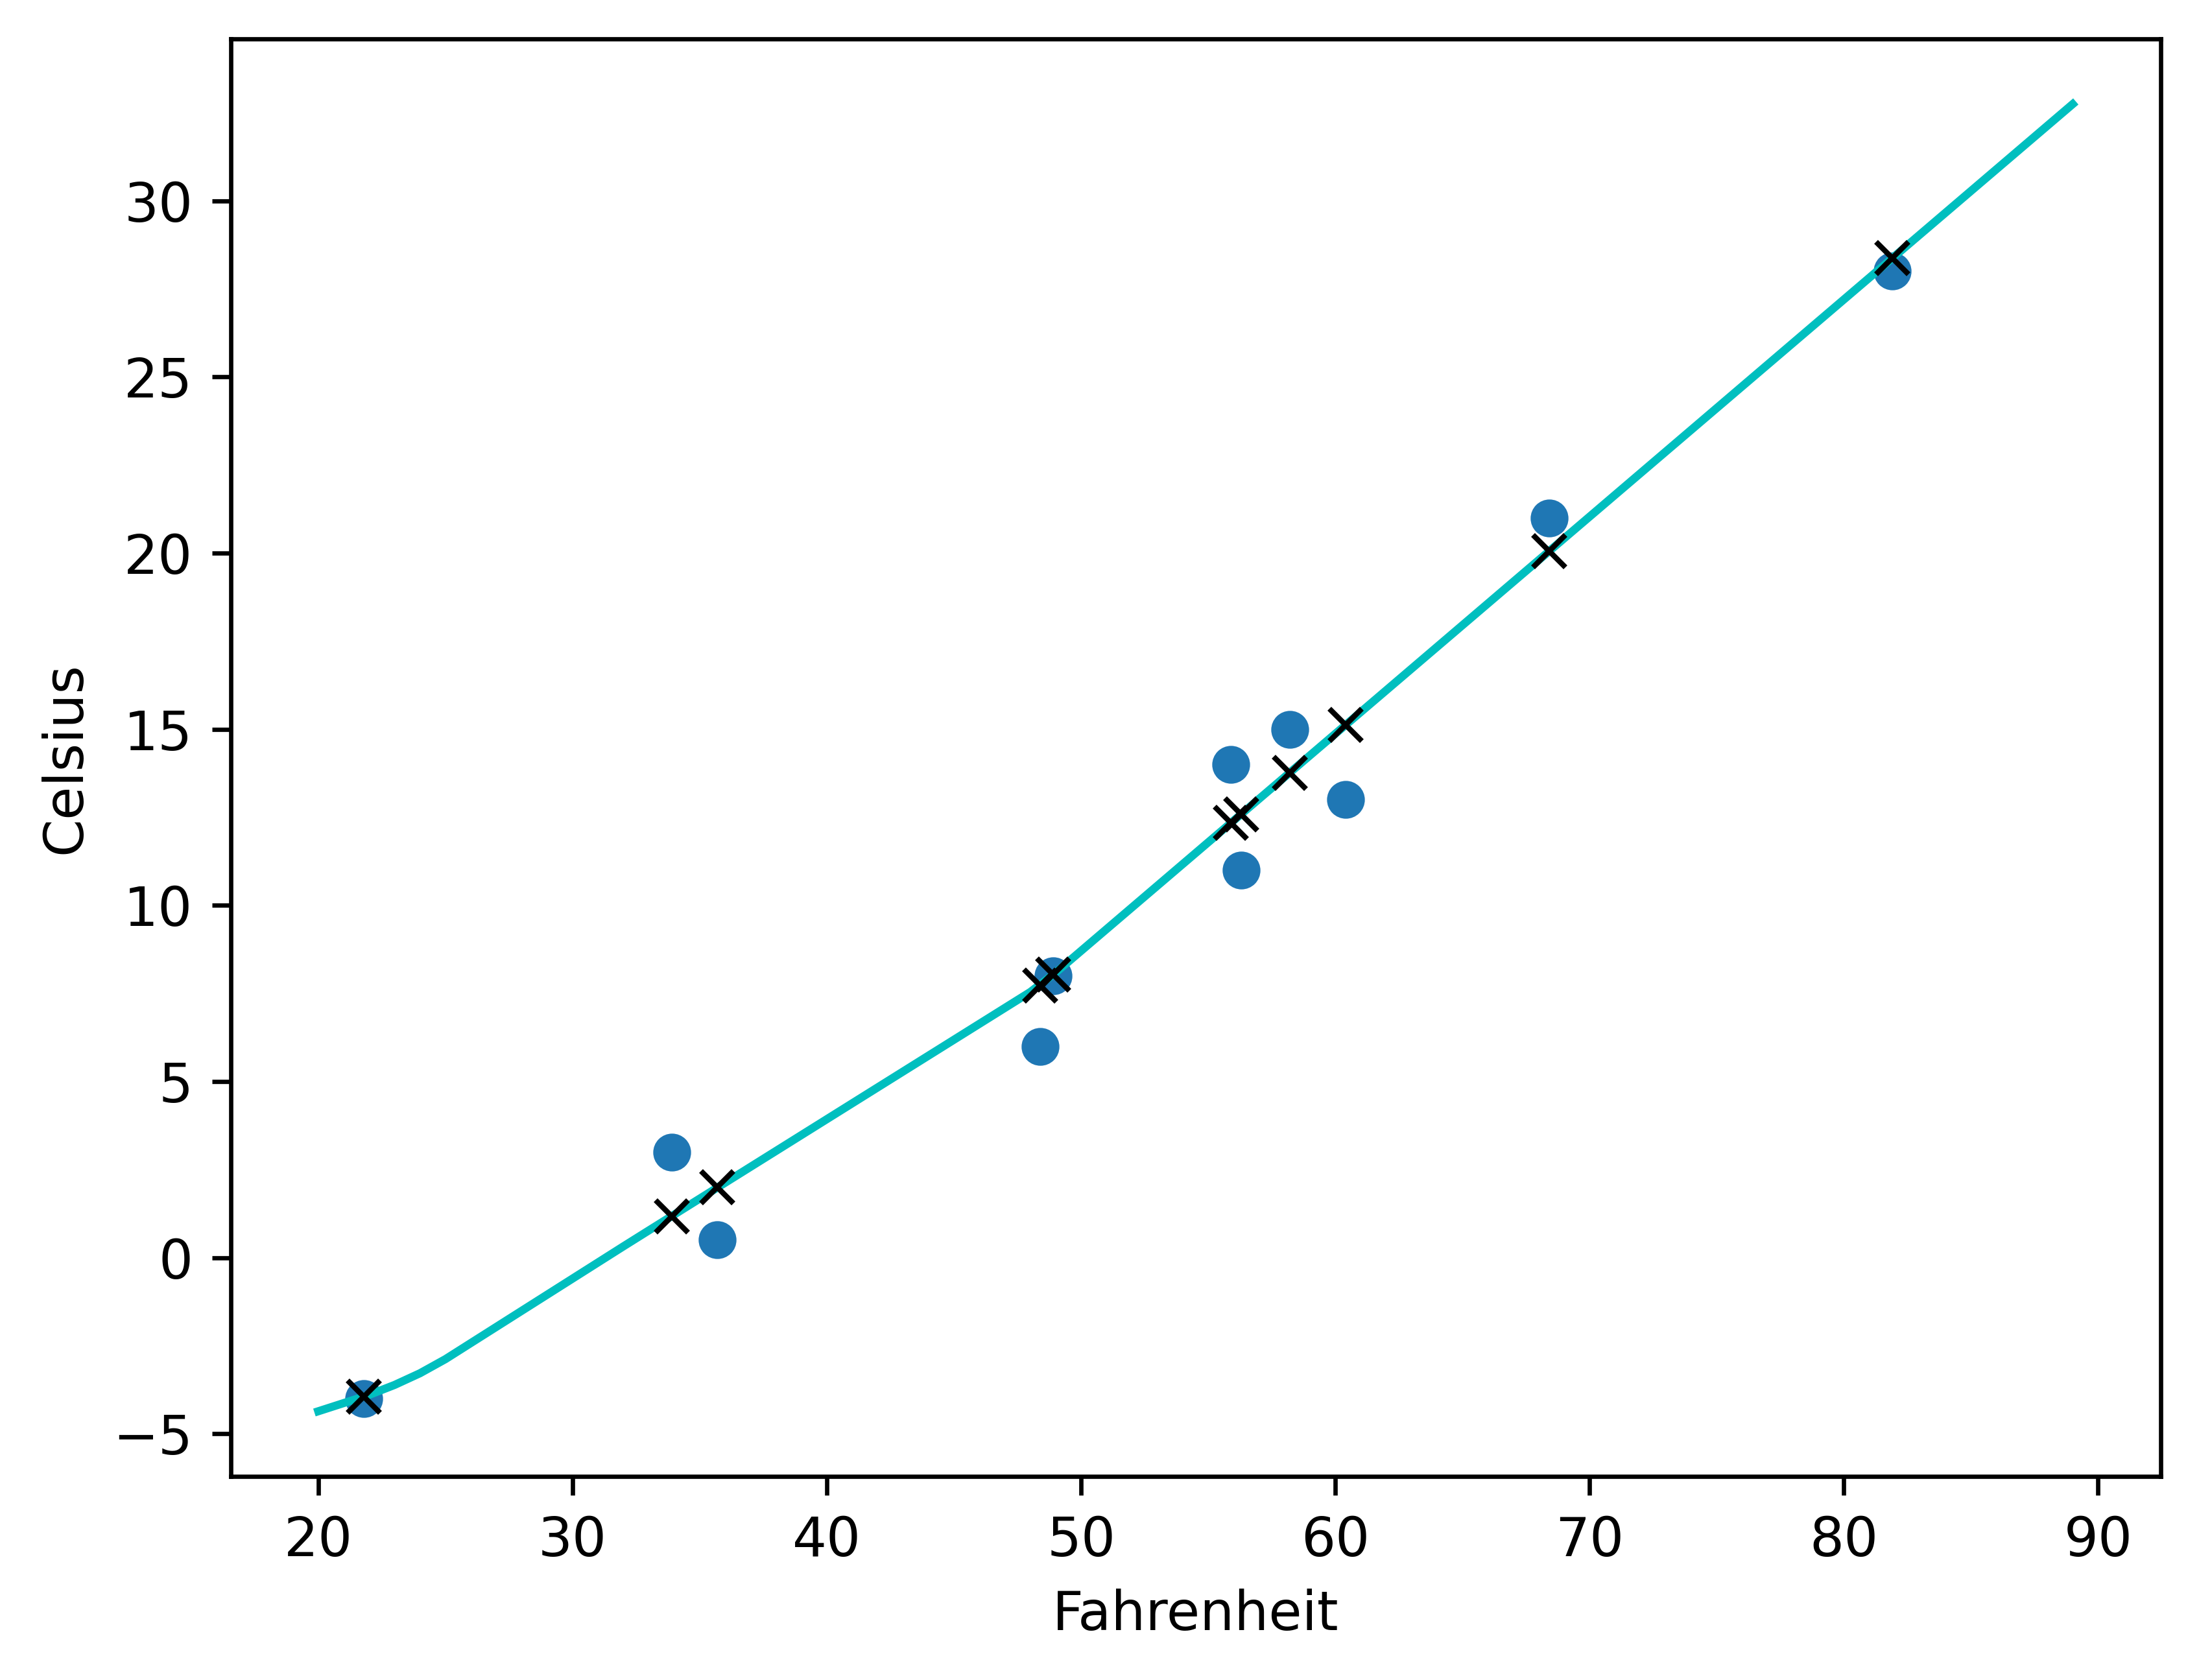

In [76]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1).to('cuda')

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.cpu().numpy(), t_c.cpu().numpy(), 'o')
plt.plot(t_range.cpu().numpy(), seq_model(0.1 * t_range).detach().cpu().numpy(), 'c-')
plt.plot(t_u.cpu().numpy(), seq_model(0.1 * t_u).detach().cpu().numpy(), 'kx')


Epoch 1, Training loss 206.3094, Validation loss 66.4969
Epoch 1000, Training loss 26.1928, Validation loss 50.9594
Epoch 2000, Training loss 22.1869, Validation loss 41.2958
Epoch 3000, Training loss 18.3709, Validation loss 32.4386
Epoch 4000, Training loss 14.7260, Validation loss 24.3243
Epoch 5000, Training loss 11.4505, Validation loss 17.2974
Epoch 6000, Training loss 8.6840, Validation loss 11.6279
Epoch 7000, Training loss 6.5236, Validation loss 7.4591
Epoch 8000, Training loss 4.9683, Validation loss 4.7106
Epoch 9000, Training loss 3.9356, Validation loss 3.1186
Epoch 10000, Training loss 3.3008, Validation loss 2.3389


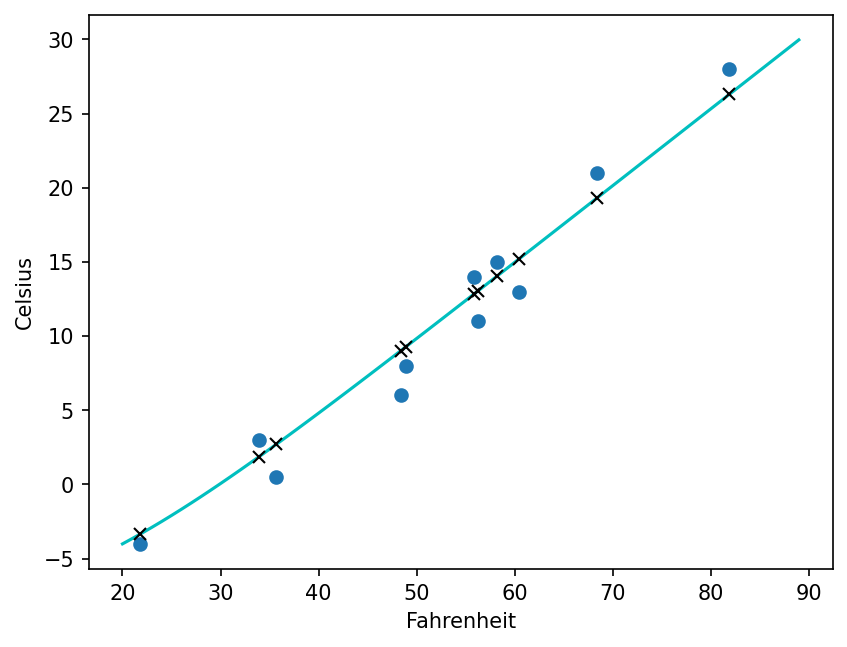

In [81]:
# Exercises here!

neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.LogSigmoid()),
    ('output_linear', nn.Linear(neuron_count, 1))
])).to('cuda')

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 10000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1).to('cuda')

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.cpu().numpy(), t_c.cpu().numpy(), 'o')
plt.plot(t_range.cpu().numpy(), seq_model(0.1 * t_range).detach().cpu().numpy(), 'c-')
plt.plot(t_u.cpu().numpy(), seq_model(0.1 * t_u).detach().cpu().numpy(), 'kx')
